# Transformer

## 1.总体架构
作用：基于 seq2seq 的模型，将输入序列转换为输出序列，可以完成经典的 NLP 任务，如机器翻译、文本摘要、文本分类等。

<img src="images/transformer.png">

分为四个部分：
* 输入
    * 源文本嵌入层和位置编码器
    * 目标文本嵌入层和位置编码器
* 输出
    * 线性层
    * softmax 层
* 编码器
    * 由 N 层编码器层堆叠而成
    * 每个编码器层由两个子层连接结构组成
    * 第一个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接
    * 第二个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接
* 解码器
    * 由 N 层解码器层堆叠而成
    * 每个解码器层由三个子层连接结构组成
    * 第一个子层连接结构包括一个多头自 注意力子层、规范化层以及一个残差连接
    * 第二个子层连接结构包括一个多头注意力子层、规范化层以及一个残差连接
    * 第三个子层连接结构包括一个前馈全连接子层、规范化层以及一个残差连接

## 2.输入部分

In [2]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable


class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        :param d_model: 词嵌入的维度
        :param vocab: 词表的大小
        """
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [3]:
d_model = 512
vocab = 1000
emb = Embeddings(d_model, vocab)
x = Variable(torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]]))
y = emb(x)
print(y)
print(y.shape)

tensor([[[ -0.6208,  -8.5809, -35.2879,  ...,  -2.0624,  20.0566,  41.4902],
         [-22.6888, -36.5084, -23.5710,  ...,  13.1157,  -8.8151,  -5.9164],
         [ 29.6924, -23.3729, -19.5666,  ...,   9.5588,  -7.0904,  -0.5596],
         [-12.0384,   6.6588, -48.2716,  ...,  12.7006,   8.1441,  -8.9028]],

        [[ 29.6924, -23.3729, -19.5666,  ...,   9.5588,  -7.0904,  -0.5596],
         [ 16.9589,  -8.5977,  12.7580,  ...,  -3.8703, -15.2159, -31.5452],
         [-22.6888, -36.5084, -23.5710,  ...,  13.1157,  -8.8151,  -5.9164],
         [ 17.0439,  -2.6029, -44.3767,  ...,   9.3770, -34.2310,  -8.0417]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


## 3.编码器

### 3.1.位置编码器

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)   # 位置编码矩阵(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)   # 位置编码向量(max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))   # 变换矩阵(1, d_model/2)，将自然数的绝对位置编码缩放成足够小的数字，有助于在后续梯度下降过程中更快地收敛
        pe[:, 0::2] = torch.sin(position * div_term)   # 偶数位置编码
        pe[:, 1::2] = torch.cos(position * div_term)   # 奇数位置编码
        pe = pe.unsqueeze(0)   # 增加维度
        self.register_buffer('pe', pe)   # 注册为缓冲区
        # 对模型效果有帮助的，但不是模型结构中的超参数或者参数，不需要随着优化步骤更新的增益对象称为缓冲区。缓冲区注册之后，可以通过模型的 state_dict() 方法保存和加载，实现在模型保存后重加载时和模型结构与参数一同被加载。
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [5]:
dropout = 0.1
max_len = 60
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(y)
print(pe_result)
print(pe_result.shape)

tensor([[[ -0.6897,  -0.0000, -39.2087,  ...,  -1.1804,  22.2851,  47.2114],
         [-24.2748, -39.9646, -25.2768,  ...,  15.6841,  -9.7944,  -5.4626],
         [ 34.0019,  -0.0000, -20.7003,  ...,  11.7320,  -7.8780,   0.4893],
         [-13.2192,   6.2986, -53.3628,  ...,  15.2228,   9.0493,  -8.7809]],

        [[ 32.9916, -24.8587, -21.7407,  ...,  11.7320,  -7.8782,   0.4893],
         [ 19.7782,  -0.0000,  15.0887,  ...,  -3.1892, -16.9064, -33.9391],
         [-24.1995, -41.0273, -25.1495,  ...,  15.6841,  -9.7943,  -5.4626],
         [  0.0000,  -3.9921, -49.0352,  ...,  11.5300, -38.0341,  -7.8241]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


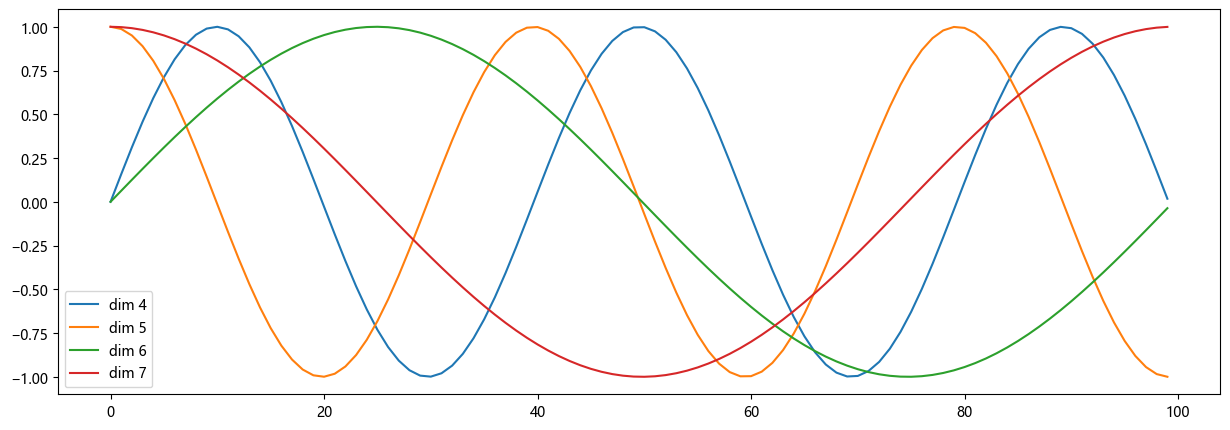

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])

## 3.2 掩码张量
1. 什么是掩码张量

    掩码张量尺寸不定，一般只含元素0和1，表示另外一个张量的对应位置的数值是否被遮掩

2. 掩码张量的作用

    在 transformer 中应用 attention 时，有一些生成的 attention 张量中的值计算有可能已知了未来信息而得到，因此需要对这些值进行遮掩，以免影响模型的训练。

In [7]:
'''
np.triu() 函数的使用

np.triu() 函数用于生成上三角矩阵，返回一个矩阵，其元素为上三角矩阵的元素，其余元素为0。
'''
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
print(np.triu(a, k=-1))
print(np.triu(a, k=0))
print(np.triu(a, k=1))

[[ 1  2  3]
 [ 4  5  6]
 [ 0  8  9]
 [ 0  0 12]]
[[1 2 3]
 [0 5 6]
 [0 0 9]
 [0 0 0]]
[[0 2 3]
 [0 0 6]
 [0 0 0]
 [0 0 0]]


In [8]:
def subsequent_mask(size):
    """
    生成向后遮掩的掩码张量，它的最后两维形成一个方阵
    :param size: 掩码张量最后两维的尺寸
    :return: 掩码张量
    """
    attn_shape = (1, size, size)    # 掩码张量的形状
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')     # 添加 1 元素，形成上三角矩阵；为了节省空间，转换为 uint8 类型
    return torch.from_numpy(1 - subsequent_mask)     # 取反，得到下三角矩阵，并转换为张量

In [9]:
size = 5
mask = subsequent_mask(size)
print(mask)

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


'\n黄色代表被遮掩，紫色代表未被遮掩\n横坐标代表目标词汇的位置，纵坐标代表可查看的位置\n'

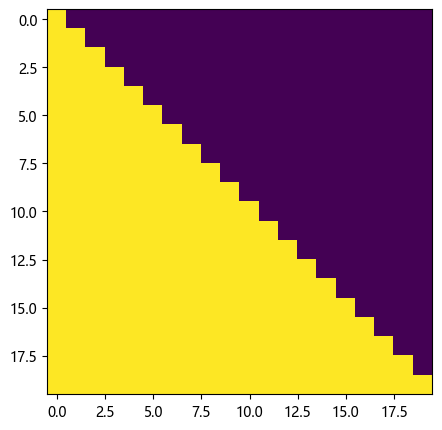

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])
'''
黄色代表被遮掩，紫色代表未被遮掩
横坐标代表目标词汇的位置，纵坐标代表可查看的位置
'''

### 3.3 注意力机制
计算规则：$$ Attention(Q, K, V) = softmax(\frac{Q K^T}{\sqrt{d_k}}) V $$

它需要三个指定的输入：Q(query)、K(key)、V(value)。计算结果代表 query 在 key 和 value 作用下的表示。

In [11]:
x = Variable(torch.randn(5, 5))
print(x)

mask = Variable(torch.zeros(5, 5))
print(mask)

y = x.masked_fill(mask == 0, -1e9)
print(y)

tensor([[-1.1692, -1.1337,  0.3577,  1.2117, -1.7714],
        [-1.2341,  1.4091,  0.9512, -0.9470, -0.3680],
        [ 0.9798, -1.4729,  2.3212,  1.3203, -0.3951],
        [ 0.6615,  2.5865, -1.2336,  1.3543,  1.0764],
        [-0.0290, -0.4930, -0.4585, -1.0860,  0.3172]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])


In [12]:
def attention(query, key, value, mask=None, dropout=None):
    """
    注意力机制的实现
    :param query: Q
    :param key: K
    :param value: V
    :param mask: 掩码张量
    :param dropout: nn.Dropout 层
    :return: 注意力张量
    """
    d_k = query.size(-1)    # 获取词嵌入维度
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)   # 计算注意力得分
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)   # 掩盖未来信息
    p_attn = nn.functional.softmax(scores, dim=-1)   # 获得最终的注意力张量
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [13]:
Q = K = V = pe_result
mask = Variable(torch.zeros(2, 4, 4))
self_attn, p_attn = attention(Q, K, V)
print(self_attn)
print(self_attn.shape)
print('-' * 50)
print(p_attn)
print(p_attn.shape)

tensor([[[ -0.6897,   0.0000, -39.2087,  ...,  -1.1804,  22.2851,  47.2114],
         [-24.2748, -39.9646, -25.2768,  ...,  15.6841,  -9.7944,  -5.4626],
         [ 34.0019,   0.0000, -20.7003,  ...,  11.7320,  -7.8780,   0.4893],
         [-13.2192,   6.2986, -53.3628,  ...,  15.2228,   9.0493,  -8.7809]],

        [[ 32.9916, -24.8587, -21.7407,  ...,  11.7320,  -7.8782,   0.4893],
         [ 19.7782,   0.0000,  15.0887,  ...,  -3.1892, -16.9064, -33.9391],
         [-24.1995, -41.0273, -25.1495,  ...,  15.6841,  -9.7943,  -5.4626],
         [  0.0000,  -3.9921, -49.0352,  ...,  11.5300, -38.0341,  -7.8241]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 512])
--------------------------------------------------
tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)
torch.Size([2, 4, 4

### 3.4 多头注意力机制
<img src="images/multi-head-attention.png">

所谓多头，即每个头从词义层面分割输出的张量，也就是只分割了最后一维的词的嵌入向量。将每个头的获得的输入送到注意力机制中，就形成了多头注意力机制。

作用：
    能够让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，从而提升模型的效果。

In [14]:
import copy


def clone(module, N):
    """
    将多个相同结构的线性层一同初始化到一个网络层列表对象中
    :param module: 要克隆的目标网络层
    :param N: 将 module 克隆 N 次
    :return: 网络层列表对象
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class MultiHeadAttention(nn.Module):
    def __init__(self, head_num, d_model, dropout=0.1):
        """
        :param head_num: 多头注意力机制的头数
        :param d_model: 词嵌入维度
        :param dropout: 进行 dropout 操作的概率
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % head_num == 0
        self.d_k = d_model // head_num   # 每个头的维度
        self.head_num = head_num
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.linears = clone(nn.Linear(d_model, d_model), 4)    # 获得 4 个线性层，分别是 Q、K、V、输出层
        self.attn = None
    
    def forward(self, query, key, value, mask=None):
        """
        :param query: Q
        :param key: K
        :param value: V
        :param mask: 掩码张量
        :return: 多头注意力结构
        """
        if mask is not None:
            mask = mask.unsqueeze(1)
        batch_size = query.size(0)
        query, key, value = [model(x).view(batch_size, -1, self.head_num, self.d_k).transpose(1, 2)     # 利用 view 和 transpose 进行维度和形状的转换
                             for x, model in zip([query, key, value], self.linears)]                    # 使用 zip 将网络层和输入数据连接在一起
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)        # 将每个头的输出传入到注意力层
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head_num * self.d_k)   # 维度重新转换回来
        return self.linears[-1](x)   # 输出层

In [15]:
head_num = 8
d_model = 512
dropout = 0.2
Q = K = V = pe_result
mask = Variable(torch.zeros(2, 4, 4))
mha = MultiHeadAttention(head_num, d_model, dropout)
mha_result = mha(Q, K, V, mask)
print(mha_result)
print(mha_result.shape)

tensor([[[-4.0643,  9.2726,  0.3721,  ...,  2.4213,  3.8549, -4.0772],
         [-3.2741,  8.6834,  3.7327,  ...,  0.8707,  1.7577,  0.1409],
         [-2.5566,  6.8601,  3.6515,  ..., -1.4673,  3.5099, -2.6835],
         [-1.0161,  9.1147,  2.4798,  ...,  2.3701,  5.1032,  0.7863]],

        [[ 8.1191,  0.1092,  0.4604,  ...,  4.6649, -8.2115,  3.0337],
         [ 9.2446,  3.1883, -0.5527,  ...,  2.3023, -4.7264,  3.8635],
         [ 5.9045,  2.4910,  0.9714,  ...,  3.6959, -5.1513,  3.3123],
         [ 7.5644,  1.5569, -0.4072,  ...,  4.5520, -7.6849,  6.3139]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


### 3.5 前馈全连接层
1. 什么是前馈全连接层

    前馈全连接层是具有两层线性层的全连接网络
2. 前馈全连接层的作用
    
    考虑到注意力机制可能对复杂过程的拟合程度不够，增加两层网络来提升模型的表达能力。

In [16]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        :param d_model: 词嵌入维度
        :param d_ff: 前馈网络的维度
        :param dropout: 进行 dropout 操作的概率
        """
        super(PositionwiseFeedForward, self).__init__()
        self.w1 = nn.Linear(d_model, d_ff)    # 第一层线性层
        self.w2 = nn.Linear(d_ff, d_model)    # 第二层线性层
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.w2(self.dropout(nn.functional.relu(self.w1(x))))

In [17]:
d_model = 512
d_ff = 128
dropout = 0.2
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
x = mha_result
ff_result = ff(x)
print(ff_result)
print(ff_result.shape)

tensor([[[ 1.2088,  1.2332,  0.1380,  ...,  0.4381,  0.2826, -1.7410],
         [ 1.7672,  0.3648,  0.8809,  ..., -0.2961,  0.0791, -0.4350],
         [-0.6416,  0.8341,  0.8582,  ..., -0.5857, -0.6429,  0.1934],
         [ 1.2007,  0.7959,  0.8635,  ..., -0.3711, -0.1414, -0.7055]],

        [[ 0.9546,  0.8462, -0.6976,  ..., -1.0930,  0.2528, -0.4543],
         [-0.2570,  0.1790, -0.6797,  ..., -0.0412,  0.4935,  0.5092],
         [ 0.3217,  1.3312, -0.1841,  ..., -0.3820,  1.0700, -0.5336],
         [-0.1945,  1.1046, -0.3881,  ..., -1.1311,  0.4010, -0.2909]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


### 3.6 规范化层
作用：由于网络层数的增加，通过多层计算后的参数可能开始出现过大或过小的情况，可能会导致学习过程出现异常，模型收敛缓慢。因此在一定层数后连接规范化层进行数值的规范化，可以使特征数值在合理范围内

In [18]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        """
        :param features: 词嵌入的维度
        :param eps: 规范化公式的分母上添加的极小值
        """
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.a2 = nn.Parameter(torch.ones(features))   # 权重参数
        self.b2 = nn.Parameter(torch.zeros(features))  # 偏置参数
        # nn.Parameter 用于将参数注册到模型的 state_dict 中，并将其转换为可训练的张量。
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)   # 对 x 进行最后一个维度上的求均值操作，同时保持输出维度和输入维度一致
        std = x.std(-1, keepdim=True)     # 对 x 进行最后一个维度上的求标准差的操作，同时保持输出维度和输入维度一致
        return self.a2 * (x - mean) / (std + self.eps) + self.b2   # 进行规范化

In [19]:
features = d_model = 512
norm = LayerNorm(features)
norm_result = norm(ff_result)
print(norm_result)
print(norm_result.shape)

tensor([[[ 1.2795e+00,  1.3054e+00,  1.4278e-01,  ...,  4.6132e-01,
           2.9624e-01, -1.8518e+00],
         [ 1.5592e+00,  2.6254e-01,  7.3978e-01,  ..., -3.4849e-01,
          -1.6199e-03, -4.7692e-01],
         [-7.8088e-01,  7.7424e-01,  7.9972e-01,  ..., -7.2200e-01,
          -7.8229e-01,  9.9090e-02],
         [ 1.2932e+00,  8.4657e-01,  9.2110e-01,  ..., -4.4097e-01,
          -1.8755e-01, -8.0994e-01]],

        [[ 1.3449e+00,  1.1928e+00, -9.7447e-01,  ..., -1.5295e+00,
           3.5972e-01, -6.3284e-01],
         [-2.9972e-01,  1.8622e-01, -7.7082e-01,  ..., -5.9135e-02,
           5.3682e-01,  5.5426e-01],
         [ 3.0089e-01,  1.2415e+00, -1.7040e-01,  ..., -3.5486e-01,
           9.9813e-01, -4.9612e-01],
         [-2.2188e-01,  1.1820e+00, -4.3101e-01,  ..., -1.2340e+00,
           4.2167e-01, -3.2601e-01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


### 3.7 子层连接结构
<img src="images/subLayer1.png">
<br>
<img src="images/subLayer2.png">

输入到子层和规范化层的过程中，使用了残差连接（跳跃连接），因此将这一部分结构整体称为子层连接。每个编码器层中都有两个子层，这两个子层加上周围的连接结构就形成了两个子层连接结构。

In [20]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        """
        :param size: 词嵌入维度
        :param dropout: 进行 dropout 操作的概率
        """
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        """
        :param x: 输入数据
        :param sublayer: 子层函数
        :return: 输出数据
        """
        return x + self.dropout(sublayer(self.norm(x)))   # 进行残差连接

In [21]:
size = d_model = 512
dropout = 0.2
head_num = 8
x = pe_result
mask = Variable(torch.zeros(2, 4, 4))
self_attn = MultiHeadAttention(head_num, d_model, dropout)
sublayer = lambda x: self_attn(x, x, x, mask=mask)
slc = SublayerConnection(size)
slc_result = slc(x, sublayer)
print(slc_result)
print(slc_result.shape)

tensor([[[-5.9306e-01,  1.3822e-01, -3.9403e+01,  ..., -1.1804e+00,
           2.2105e+01,  4.6918e+01],
         [-2.4168e+01, -3.9798e+01, -2.5384e+01,  ...,  1.6006e+01,
          -9.7944e+00, -5.6865e+00],
         [ 3.3878e+01,  2.4269e-01, -2.0819e+01,  ...,  1.1914e+01,
          -8.0853e+00,  2.3463e-01],
         [-1.3325e+01,  6.4427e+00, -5.3452e+01,  ...,  1.5404e+01,
           8.8495e+00, -9.1727e+00]],

        [[ 3.3012e+01, -2.4360e+01, -2.1515e+01,  ...,  1.2077e+01,
          -8.1947e+00,  5.5503e-01],
         [ 1.9626e+01,  4.1059e-01,  1.5292e+01,  ..., -3.0505e+00,
          -1.7255e+01, -3.3900e+01],
         [-2.4169e+01, -4.0632e+01, -2.4950e+01,  ...,  1.5792e+01,
          -9.9894e+00, -5.3380e+00],
         [-3.8007e-02, -3.8188e+00, -4.8894e+01,  ...,  1.1633e+01,
          -3.8176e+01, -7.6992e+00]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


### 3.8 编码器层
<img src="images/encoder.png">

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        :param size: 词嵌入维度
        :param self_attn: 多头自注意力子层
        :param feed_forward: 前馈全连接层
        :param dropout: 进行 dropout 操作的概率
        """
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SublayerConnection(size, dropout), 2)   # 两个子层连接结构
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask=mask))   # 第一个子层连接结构
        return self.sublayer[1](x, self.feed_forward)   # 第二个子层连接结构

In [23]:
size = d_model = 512
head_num = 8
d_ff = 128
dropout = 0.2
x = pe_result
self_attn = MultiHeadAttention(head_num, d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(2, 4, 4))
el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)
print(el_result)
print(el_result.shape)

tensor([[[-1.1317e-01,  2.7362e-01, -3.9542e+01,  ..., -1.3976e+00,
           2.2489e+01,  4.6884e+01],
         [-2.4292e+01, -3.9390e+01, -2.5861e+01,  ...,  1.5413e+01,
          -9.8277e+00, -5.7875e+00],
         [ 3.3878e+01, -5.2278e-02, -2.0624e+01,  ...,  1.0774e+01,
          -7.8829e+00,  3.3198e-01],
         [-1.3127e+01,  6.2453e+00, -5.3291e+01,  ...,  1.4970e+01,
           9.0493e+00, -8.8911e+00]],

        [[ 3.2997e+01, -2.4688e+01, -2.1467e+01,  ...,  1.0902e+01,
          -7.6245e+00,  2.8175e-01],
         [ 1.9629e+01,  2.4237e-01,  1.5757e+01,  ..., -3.7227e+00,
          -1.6430e+01, -3.4484e+01],
         [-2.4204e+01, -4.0575e+01, -2.5072e+01,  ...,  1.5443e+01,
          -9.6176e+00, -5.3999e+00],
         [ 1.1076e-01, -3.5924e+00, -4.8812e+01,  ...,  1.1530e+01,
          -3.8066e+01, -7.8265e+00]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


### 3.9 编码器的实现

In [24]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        """
        :param layer: 编码器层
        :param N: 编码器层的数量
        """
        super(Encoder, self).__init__()
        self.layers = clone(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        """
        :param x: 输入数据
        :param mask: 掩码张量
        :return: 输出数据
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [25]:
size = d_model = 512
head_num = 8
d_ff = 128
dropout = 0.2
x = pe_result
self_attn = MultiHeadAttention(head_num, d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(2, 4, 4))
c = copy.deepcopy
layer = EncoderLayer(size, c(self_attn), c(ff), dropout)
N = 8
encoder = Encoder(layer, N)
encoder_result = encoder(x, mask)
print(encoder_result)
print(encoder_result.shape)

tensor([[[ 0.1118, -0.0833, -1.5793,  ..., -0.1063,  0.8935,  1.9514],
         [-1.0022, -1.7634, -1.0895,  ...,  0.6150, -0.4006, -0.2581],
         [ 1.5186, -0.1797, -1.0525,  ...,  0.5164, -0.3138, -0.0052],
         [-0.3194,  0.2118, -2.2547,  ...,  0.6564,  0.4316, -0.3521]],

        [[ 1.4518, -1.2516, -1.0927,  ...,  0.4658, -0.2583,  0.0978],
         [ 0.9353,  0.0439,  0.6113,  ..., -0.0953, -0.5856, -1.3279],
         [-1.0033, -1.7411, -1.0353,  ...,  0.5827, -0.3225, -0.2090],
         [ 0.0840, -0.2736, -2.0817,  ...,  0.3079, -1.4709, -0.3474]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 4. 解码器

### 4.1 解码器层
<img src="images/decoder.png">

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        """
        :param size: 词嵌入维度
        :param self_attn: 多头自注意力子层
        :param src_attn: 多头注意力子层(Q != K = V)
        :param feed_forward: 前馈全连接层
        :param dropout: 进行 dropout 操作的概率
        """
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SublayerConnection(size, dropout), 3)   # 三个子层连接结构
    
    def forward(self, x, memory, src_mask, target_mask):
        """
        :param x: 输入数据
        :param memory: 编码器的语义存储变量
        :param src_mask: 编码器的掩码张量
        :param target_mask: 解码器的掩码张量
        :return: 输出数据
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask=target_mask))   # 第一个子层连接结构
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, mask=src_mask))   # 第二个子层连接结构
        return self.sublayer[2](x, self.feed_forward)   # 第三个子层连接结构

In [27]:
head_num = 8
size = d_model = 512
d_ff = 128
dropout = 0.2
self_attn = src_attn = MultiHeadAttention(head_num, d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
x = pe_result
memory = encoder_result
mask = Variable(torch.zeros(2, 4, 4))
src_mask = target_mask = mask
dl = DecoderLayer(size, self_attn, src_attn, ff, dropout)
dl_result = dl(x, memory, src_mask, target_mask)
print(dl_result)
print(dl_result.shape)

tensor([[[ -1.1702,   0.3942, -38.7966,  ...,  -1.0059,  21.7834,  46.8454],
         [-23.7760, -38.9992, -25.0647,  ...,  14.9769, -10.1940,  -5.6814],
         [ 33.8833,   0.7017, -20.8356,  ...,  12.0816,  -8.3004,   0.1807],
         [-13.3855,   6.3044, -53.3739,  ...,  15.0069,   7.9331,  -8.9402]],

        [[ 32.6685, -24.4979, -21.8571,  ...,  11.2845,  -7.7926,   0.8874],
         [ 20.0208,   0.6335,  15.0115,  ...,  -3.9046, -16.6591, -34.4058],
         [-24.4539, -40.4801, -25.7478,  ...,  13.9346,  -9.7738,  -5.2782],
         [  0.0000,  -3.8514, -49.5103,  ...,  11.1152, -37.9041,  -6.7724]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


### 4.2 解码器的实现

In [28]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        """
        :param layer: 解码器层
        :param N: 解码器层的数量
        """
        super(Decoder, self).__init__()
        self.layers = clone(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, target_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, target_mask)
        return self.norm(x)

In [29]:
size = d_model = 512
head_num = 8
d_ff = 128
dropout = 0.2
self_attn = src_attn = MultiHeadAttention(head_num, d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
x = pe_result
memory = encoder_result
mask = Variable(torch.zeros(2, 4, 4))
src_mask = target_mask = mask
layer = DecoderLayer(size, c(self_attn), c(src_attn), c(ff), dropout)
N = 8
decoder = Decoder(layer, N)
decoder_result = decoder(x, memory, src_mask, target_mask)
print(decoder_result)
print(decoder_result.shape)

tensor([[[-0.2097,  0.0734, -1.6370,  ..., -0.2772,  0.9232,  1.9315],
         [-1.0297, -1.6574, -1.1198,  ...,  0.3956, -0.3668, -0.1820],
         [ 1.2885,  0.0250, -0.7926,  ...,  0.1922, -0.4382, -0.1751],
         [-0.5213,  0.2266, -2.1882,  ...,  0.3954,  0.3495, -0.3945]],

        [[ 1.3869, -1.0312, -0.8455,  ...,  0.4594, -0.3559, -0.1418],
         [ 0.8887,  0.1845,  0.7110,  ...,  0.0523, -0.6431, -1.4509],
         [-0.9120, -1.5849, -1.1749,  ...,  0.6251, -0.3135, -0.2737],
         [ 0.0217, -0.0678, -2.0428,  ...,  0.4443, -1.5702, -0.4152]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 5.输出部分
<img src="images/transformer_output.png">

* 线性层的作用：转换维度
* softmax 层的作用：将输出的概率分布转换为概率值

In [30]:
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        """
        :param d_model: 词嵌入维度
        :param vocab_size: 词汇表大小
        """
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [31]:
d_model = 512
vocab_size = 1000
generator = Generator(d_model, vocab_size)
x = decoder_result
output = generator(x)
print(output)
print(output.shape)

tensor([[[-6.8639, -7.6947, -7.3791,  ..., -6.9736, -7.2633, -6.6993],
         [-7.6929, -7.8023, -7.2760,  ..., -8.0304, -7.5927, -7.5996],
         [-7.0825, -7.0828, -6.2750,  ..., -7.3796, -6.4972, -6.6149],
         [-7.2636, -7.2150, -6.8405,  ..., -6.8845, -6.0645, -8.0201]],

        [[-6.6980, -7.1293, -6.1708,  ..., -7.3360, -6.4333, -6.8496],
         [-7.5527, -6.6044, -7.1022,  ..., -6.9781, -7.3132, -6.8742],
         [-7.9385, -7.6115, -7.0067,  ..., -8.6383, -7.8844, -7.7334],
         [-7.4878, -7.1445, -7.6197,  ..., -7.7820, -6.9919, -7.2133]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 4, 1000])


## 6.完整的模型

In [32]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, target_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.target_embed = target_embed
        self.generator = generator
    
    def forward(self, src, target, src_mask, target_mask):
        return self.decode(self.encode(src, src_mask), src_mask, target, target_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, target, target_mask):
        return self.decoder(self.target_embed(target), memory, src_mask, target_mask)

In [3]:
d_model = 512
vocab_size = 1000
src_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
src = target = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
src_mask = target_mask = Variable(torch.ones(2, 4, 4))
ed = EncoderDecoder(encoder, decoder, src_embed, target_embed, generator)
ed_result = ed(src, target, src_mask, target_mask)
print(ed_result)
print(ed_result.shape)

NameError: name 'nn' is not defined

In [37]:
def create_model(src_vocab_size, target_vocab_size, N=6, d_model=512, d_ff=2048, head_num=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(head_num, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab_size), c(position)),
        nn.Sequential(Embeddings(d_model, target_vocab_size), c(position)),
        Generator(d_model, target_vocab_size)
    )
    # 初始化参数
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)   # 初始化成一个服从均匀分布的矩阵
    return model

In [ ]:
src_vocab_size = 1000
target_vocab_size = 1000
model = create_model(src_vocab_size, target_vocab_size)
print(model)